<h1>A Two-layer Collaborative Vehicle-Edge Intrusion
Detection System for Vehicular Communications</h1>


---



In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/Surrey/Dissertation")

Mounted at /content/drive


# Concatenate Data

This section combines all source files into a single csv file

In [3]:
# Read data
# monday = pd.read_csv('./Data/Monday-WorkingHours.pcap_ISCX.csv')
# tuesday = pd.read_csv('./Data/Tuesday-WorkingHours.pcap_ISCX.csv')
# wednesday = pd.read_csv('./Data/Wednesday-workingHours.pcap_ISCX.csv')
# thursday_WebAttacks = pd.read_csv('./Data/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv')
# thursday_Infilteration = pd.read_csv('./Data/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv')
# friday = pd.read_csv('./Data/Friday-WorkingHours-Morning.pcap_ISCX.csv')
# friday_PortScan = pd.read_csv('./Data/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv')
# friday_DDOS = pd.read_csv('./Data/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')

In [4]:
# Number of rows and column
# print(monday.shape)
# print(tuesday.shape)
# print(wednesday.shape)
# print(thursday_WebAttacks.shape)
# print(thursday_Infilteration.shape)
# print(friday.shape)
# print(friday_PortScan.shape)
# print(friday_DDOS.shape)

In [5]:
# # combine into one dataframe
# data = pd.DataFrame()
# data = pd.concat([data, monday])
# data = pd.concat([data, tuesday])
# data = pd.concat([data, wednesday])
# data = pd.concat([data, thursday_WebAttacks])
# data = pd.concat([data, thursday_Infilteration])
# data = pd.concat([data, friday])
# data = pd.concat([data, friday_PortScan])
# data = pd.concat([data, friday_DDOS])

# # drop duplicated rows
# data.drop_duplicates(keep='first', inplace=True)
# data.to_csv('./Data/combined.csv', index=False)

# Read Data

In [6]:
data = pd.read_csv('./Data/combined.csv', encoding='utf-8')
data.columns = [c.strip() for c in data.columns]

In [7]:
data.shape

(2522362, 79)

In [8]:
data.columns

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Co

In [9]:
data['Label'] = data['Label'].apply(lambda x: re.sub('[^0-9a-zA-Z -]+', '', x))
data['Label'] = data['Label'].apply(lambda x: re.sub(' +', ' ', x))
data['Label'].unique()

array(['BENIGN', 'FTP-Patator', 'SSH-Patator', 'DoS slowloris',
       'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye', 'Heartbleed',
       'Web Attack Brute Force', 'Web Attack XSS',
       'Web Attack Sql Injection', 'Infiltration', 'Bot', 'PortScan',
       'DDoS'], dtype=object)

visualise number of samples in each class

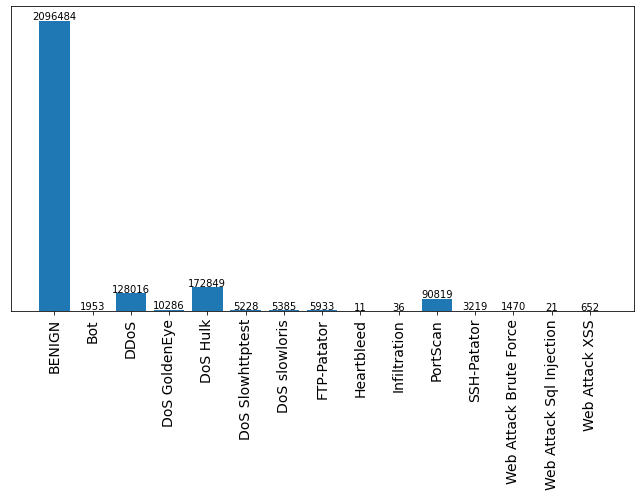

In [10]:
unique, counts = np.unique(data['Label'], return_counts=True)

plt.figure(figsize=(9,7))
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=16)

plt.bar(unique, counts)
for i in range(len(unique)):
    plt.text(i,counts[i]+10000,counts[i], ha = 'center')
plt.xticks(unique, rotation=90)
plt.yticks([])
plt.tight_layout()
plt.savefig("plots/all_data_distribution.pdf", format="pdf")
plt.show()

# Pre-processing

<h3>Convert to binary class</h3>

In [11]:
normal_class = 'BENIGN'
output_column = 'Label_binary'

data[output_column] = data['Label'].apply(lambda x: 0 if x==normal_class else 1)

In [12]:
data.groupby(output_column)['Destination Port'].count()

Label_binary
0    2096484
1     425878
Name: Destination Port, dtype: int64

<h3>
Separate X and Y
</h3>

In [13]:
# Shuffle rows
# data = data.sample(frac = 1).reset_index(drop=True)
# Separate X and Y
X = data.drop(columns=[output_column]).copy()
Y = data[output_column]

<h3>Label encoding</h3>

In [14]:
from sklearn.preprocessing import LabelEncoder
class_le = LabelEncoder()

Y = class_le.fit_transform(Y)

In [15]:
multiclass_le = LabelEncoder()

X['Label'] = multiclass_le.fit_transform(X['Label'])

<h3>NA and INF values
</h3>

Replace NA and INF values by mean of the column

In [16]:
X_check_na_inf = X.copy()
X_check_na_inf.columns.to_series()[np.isinf(X_check_na_inf).any()]      # identify columns with NA/INF values

Flow Bytes/s        Flow Bytes/s
Flow Packets/s    Flow Packets/s
dtype: object

In [17]:
def fill_na_inf(data, columns):
    for column in columns:
        mean = data.loc[-((data[column]==np.inf) | (data[column].isnull())), column].mean()
        data.loc[(data[column]==np.inf) | (data[column].isnull()), column] = mean
    return data

In [18]:
X = fill_na_inf(X, ['Flow Bytes/s', 'Flow Packets/s'])

In [19]:
X.isnull().sum().sum()

0

<h1>Remove columns with 1 unique value only
</h1>

In [20]:
remove = []
for c in X.columns:
    # columns with 1 unique value only, will be removed later
    if X[c].nunique() == 1:
        remove.append(c)

print(remove)

['Bwd PSH Flags', 'Bwd URG Flags', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']


remove columns

In [21]:
X.drop(columns=remove, inplace=True)

<h1>
Identify categorical columns
</h1>

In [22]:
cat_cols = []
for c in X.columns:
    # Categorical columns
    if X[c].nunique()<10:
        cat_cols.append(c)
        print(c, X[c].nunique())

cat_cols.append('Label')

Fwd PSH Flags 2
Fwd URG Flags 2
FIN Flag Count 2
SYN Flag Count 2
RST Flag Count 2
PSH Flag Count 2
ACK Flag Count 2
URG Flag Count 2
CWE Flag Count 2
ECE Flag Count 2


In [23]:
X.shape # 71 instead of 70, since 'Label' column is not removed yet

(2522362, 71)

<h1>
Feature Scaling
</h1>

In [24]:
# separate discrete and continuous columns
X_discrete          = X[cat_cols]
number_of_discrete  = len(cat_cols)

# remove discrete columns to avoid being scaled
X.drop(columns=cat_cols, inplace=True)

In [25]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
num_of_continuous = len(X_scaled.columns)

# combine categorical and scaled dataframes
X_scaled = pd.concat([X_scaled, X_discrete], axis=1, join='inner')

<h1>
Split training and testing data
</h1>

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.20, random_state=1, stratify=Y, shuffle=True)

# extract the multiclass output label
Y_train_multi = X_train['Label']
Y_test_multi = X_test['Label']

X_train.drop(columns=['Label'], inplace=True)
X_test.drop(columns=['Label'], inplace=True)

In [27]:
X_train.shape

(2017889, 70)

class distribution of training data

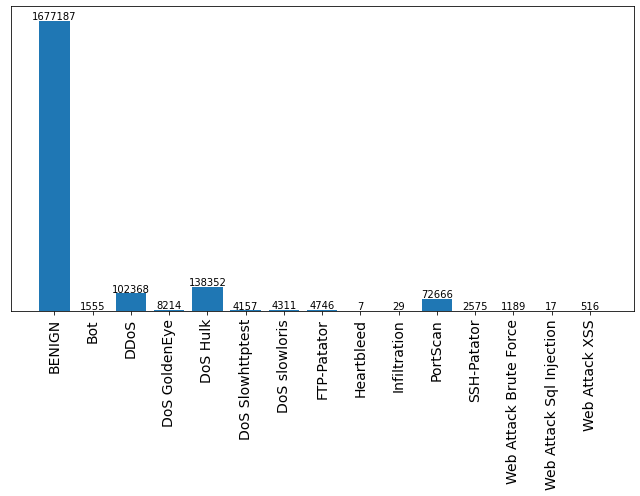

In [28]:
unique, counts = np.unique(Y_train_multi, return_counts=True)

plt.figure(figsize=(9,7))
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=16)

plt.bar(multiclass_le.classes_, counts)
for i in range(len(unique)):
    plt.text(i,counts[i]+10000,counts[i], ha = 'center')
plt.xticks(multiclass_le.classes_, rotation=90)
plt.yticks([])
plt.tight_layout()
plt.savefig("plots/training_data_distribution.pdf", format="pdf")
plt.show()

class distribution of testing data

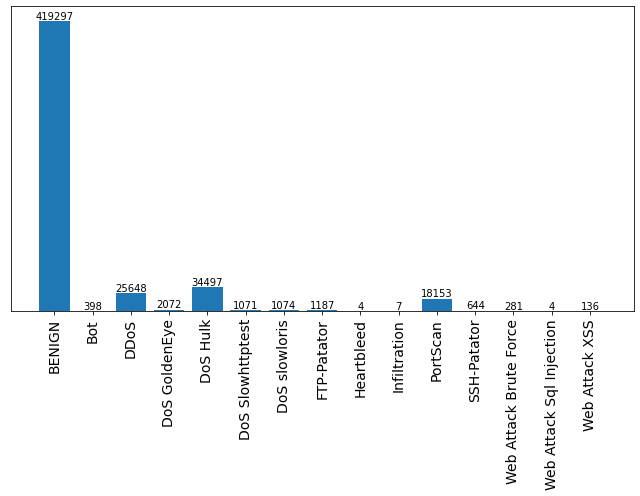

In [29]:
unique, counts = np.unique(Y_test_multi, return_counts=True)

plt.figure(figsize=(9,7))
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=16)

plt.bar(multiclass_le.classes_, counts)
for i in range(len(unique)):
    plt.text(i,counts[i]+3000,counts[i], ha = 'center')
plt.xticks(multiclass_le.classes_, rotation=90)
plt.yticks([])
plt.tight_layout()
plt.savefig("plots/testing_data_distribution.pdf", format="pdf")
plt.show()

<h1>
Dimensionality Reduction
</h1>

by correlation

In [32]:
def find_correlation(df, threshold):
    """
    This function finds highly correlated features and return a list of features to remove

    params:
    - df : pd.DataFrame
    - thresh : correlation threshold, one of pairs of features with a correlation greater than this value will be included in the output list
    """
    
    corrMatrix = df.corr()
    corrMatrix.loc[:,:] =  np.tril(corrMatrix, k=-1)

    included = set()
    result = []

    for col in corrMatrix:
        correlated = corrMatrix[col][corrMatrix[col] > threshold].index.tolist()
        if correlated and col not in included:
            included.update(set(correlated))
            correlated.append(col)
            result.append(correlated)


    select_nested = [f[1:] for f in result]
    select_flat = [i for j in select_nested for i in j]
    return select_flat

In [33]:
corr_remove = find_correlation(X_train, threshold=0.95)
corr_remove

['Flow Duration',
 'Total Length of Bwd Packets',
 'Subflow Fwd Packets',
 'Subflow Bwd Packets',
 'Subflow Bwd Bytes',
 'Total Fwd Packets',
 'Total Length of Fwd Packets',
 'Fwd Packet Length Max',
 'Fwd Packet Length Mean',
 'Bwd Packet Length Std',
 'Avg Bwd Segment Size',
 'Bwd Packet Length Max',
 'Flow Packets/s',
 'Idle Mean',
 'Idle Max',
 'Idle Min',
 'Flow IAT Max',
 'Fwd Header Length',
 'Max Packet Length',
 'Packet Length Mean',
 'Fwd PSH Flags',
 'Fwd URG Flags',
 'RST Flag Count']

remove columns

In [ ]:
X_train.drop(columns=corr_remove, inplace=True)
X_test.drop(columns=corr_remove, inplace=True)

In [35]:
X_train.shape

(2017889, 47)

<h1>Feature selection</h1>

In [36]:
# from sklearn.feature_selection import mutual_info_classif

# information_gain = mutual_info_classif(X_train, Y_train)
# ig_result = dict(zip(X_train.columns,information_gain))
# ig_result = {key: val for key, val in sorted(ig_result.items(), key = lambda ele: ele[1], reverse = True)}

information gain result

In [37]:
ig_result = {'ACK Flag Count': 0.03721031875220038,
            'Active Max': 0.15058562159923272,
            'Active Mean': 0.152560651854168,
            'Active Min': 0.15172516497255262,
            'Active Std': 0.01647303326155969,
            'Average Packet Size': 0.3508282938529179,
            'Avg Fwd Segment Size': 0.20578010325906781,
            'Bwd Header Length': 0.20162204263293515,
            'Bwd IAT Max': 0.1691778834923019,
            'Bwd IAT Mean': 0.1429574733455372,
            'Bwd IAT Min': 0.11010576744374112,
            'Bwd IAT Std': 0.11253308923679994,
            'Bwd IAT Total': 0.1552078688651375,
            'Bwd Packet Length Mean': 0.2928799498118222,
            'Bwd Packet Length Min': 0.09129561683014686,
            'Bwd Packets/s': 0.17641204437638014,
            'CWE Flag Count': 0.00021586827873787406,
            'Destination Port': 0.2669324186974802,
            'Down/Up Ratio': 0.01586505691600104,
            'ECE Flag Count': 0.00014989390953323856,
            'FIN Flag Count': 0.02617829813548478,
            'Flow Bytes/s': 0.18786629291851997,
            'Flow IAT Mean': 0.17380193260239185,
            'Flow IAT Min': 0.062330402434290555,
            'Flow IAT Std': 0.162013149104554,
            'Fwd Header Length.1': 0.12816674929272787,
            'Fwd IAT Max': 0.22974236872508058,
            'Fwd IAT Mean': 0.20472151806989425,
            'Fwd IAT Min': 0.062024857149186596,
            'Fwd IAT Std': 0.17407433290339558,
            'Fwd IAT Total': 0.21679335041156822,
            'Fwd Packet Length Min': 0.09540887133306453,
            'Fwd Packet Length Std': 0.2109347215986752,
            'Fwd Packets/s': 0.1682377158587791,
            'Idle Std': 0.024569769597473146,
            'Init_Win_bytes_backward': 0.26321869128660036,
            'Init_Win_bytes_forward': 0.2505055284336204,
            'Min Packet Length': 0.09505238249438275,
            'PSH Flag Count': 0.036852367333535696,
            'Packet Length Std': 0.33440862144595696,
            'Packet Length Variance': 0.3344485724081425,
            'SYN Flag Count': 0.006002628858968961,
            'Subflow Fwd Bytes': 0.27023019989052965,
            'Total Backward Packets': 0.13167339236995046,
            'URG Flag Count': 0.021482396503669676,
            'act_data_pkt_fwd': 0.05408351948903367,
            'min_seg_size_forward': 0.1383675623058369}

In [38]:
len(ig_result)

47

In [39]:
index = [
         np.array([0.25]*len([key for key, val in ig_result.items() if val >= 0.25])
         +[0.2]*len([key for key, val in ig_result.items() if val >= 0.2 and val < 0.25])
         +[0.15]*len([key for key, val in ig_result.items() if val >= 0.15 and val < 0.2])
         +[0.1]*len([key for key, val in ig_result.items() if val >= 0.1 and val < 0.15])
         +[0.05]*len([key for key, val in ig_result.items() if val >= 0.05 and val < 0.1])
         +[0]*len([key for key, val in ig_result.items() if val >= 0 and val < 0.05])),

         np.array([8]*len([key for key, val in ig_result.items() if val >= 0.25])
         +[14]*len([key for key, val in ig_result.items() if val >= 0.2 and val < 0.25])
         +[25]*len([key for key, val in ig_result.items() if val >= 0.15 and val < 0.2])
         +[31]*len([key for key, val in ig_result.items() if val >= 0.1 and val < 0.15])
         +[37]*len([key for key, val in ig_result.items() if val >= 0.05 and val < 0.1])
         +[47]*len([key for key, val in ig_result.items() if val >= 0 and val < 0.05])),

         np.array(['']*len([key for key, val in ig_result.items() if val >= 0.25])
         +['']*len([key for key, val in ig_result.items() if val >= 0.2 and val < 0.25])
         +['']*len([key for key, val in ig_result.items() if val >= 0.15 and val < 0.2])
         +['']*len([key for key, val in ig_result.items() if val >= 0.1 and val < 0.15])
         +['']*len([key for key, val in ig_result.items() if val >= 0.05 and val < 0.1])
         +['']*len([key for key, val in ig_result.items() if val >= 0 and val < 0.05]))
]


data = [key for key in dict(sorted(ig_result.items(),key= lambda x:x[1], reverse=True))]

table = pd.DataFrame(data, columns=["Feature"], index=index)
table.index.names = ['Information Gain','Number of features', '']
table

Feature
Information Gain Number of features                          
0.25             8                        Average Packet Size
                                       Packet Length Variance
                                            Packet Length Std
                                       Bwd Packet Length Mean
                                            Subflow Fwd Bytes
                                             Destination Port
                                      Init_Win_bytes_backward
                                       Init_Win_bytes_forward
0.20             14                               Fwd IAT Max
                                                Fwd IAT Total
                                        Fwd Packet Length Std
                                         Avg Fwd Segment Size
                                                 Fwd IAT Mean
                                            Bwd Header Length
0.15             25                              Flow Bytes/s
                                                Bwd Packets/s
                                                  Fwd IAT Std
                                                Flow IAT Mean
                                                  Bwd IAT Max
                                                Fwd Packets/s
                                                 Flow IAT Std
                                                Bwd IAT Total
                                                  Active Mean
                                                   Active Min
                                                   Active Max
0.10             31                              Bwd IAT Mean
                                         min_seg_size_forward
                                       Total Backward Packets
                                          Fwd Header Length.1
                                                  Bwd IAT Std
                                                  Bwd IAT Min
0.05             37                     Fwd Packet Length Min
                                            Min Packet Length
                                        Bwd Packet Length Min
                                                 Flow IAT Min
                                                  Fwd IAT Min
                                             act_data_pkt_fwd
0.00             47                            ACK Flag Count
                                               PSH Flag Count
                                               FIN Flag Count
                                                     Idle Std
                                               URG Flag Count
                                                   Active Std
                                                Down/Up Ratio
                                               SYN Flag Count
                                               CWE Flag Count
                                               ECE Flag Count

# Train models for first layer binary classification IDS

import libraries

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn import svm

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve

from sklearn.model_selection import cross_val_score

from copy import deepcopy

Define information gain thresholds

In [ ]:
ig_test_values = [0, 0.05, 0.1, 0.15, 0.2, 0.25]        # infomration gain threshold
x_axis = []                                             # number of features of each information gain threshold
for ig in ig_test_values:
    selected_cols = [key for key, val in ig_result.items() if val >= ig]
    x_axis.append(len(selected_cols))

Train and Evaluate the model

Evaluation metrics:


*   Accuracy
*   Precision
*   Recall
*   F1 Score






In [ ]:
def test_ig(model):

    model_list = []
    accuracy = []
    precision = []
    recall = []
    f1 = []
    report = []
    cm = []

    for ig_test in ig_test_values:
        # select columns according to information gain threshold
        selected_cols = [key for key, val in ig_result.items() if val > ig_test]
        
        # train the model
        model.fit(X_train[selected_cols], Y_train)
        model_fitted = deepcopy(model)

        # Get predicted classes
        predict = model.predict(X_test[selected_cols])
        
        # compute evaluation metrics
        model_list.append(model_fitted)
        accuracy.append(accuracy_score(y_true=Y_test, y_pred=predict))
        precision.append(precision_score(y_true=Y_test, y_pred=predict, average='weighted'))
        recall.append(recall_score(y_true=Y_test, y_pred=predict, average='weighted'))
        f1.append(f1_score(y_true=Y_test, y_pred=predict, average='weighted'))
        report.append(classification_report(y_true=Y_test, y_pred=predict))
        cm.append(confusion_matrix(y_true=Y_test, y_pred=predict))
        
    return model_list, accuracy, precision, recall, f1, report, cm

In [ ]:
x_axis

[47, 37, 31, 25, 14, 8]

visualise evaluation metrics against information gain thresholds

In [ ]:
def plot_test_ig(accuracy, precision, recall, f1):
    """
    plot accuracy, precision, recall, F1 score against information gain thresholds of a model
    """
    fig, axs = plt.subplots(2, 2)
    axs[0, 0].plot(x_axis, accuracy)
    axs[0, 0].set_title('Accuracy')
    axs[0, 1].plot(x_axis, precision)
    axs[0, 1].set_title('Precision')
    axs[1, 0].plot(x_axis, recall)
    axs[1, 0].set_title('Recall')
    axs[1, 1].plot(x_axis, f1)
    axs[1, 1].set_title('F1')

     # 1. Change to number of features
     # 2. State the Parameter used

    for ax in axs.flat:
        ax.set(xlabel='Number of features', ylabel='value', xticks=x_axis)

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()

function to save the results

In [ ]:
models_dict = {}
accuracy_dict = {}
precision_dict = {}
recall_dict = {}
f1_dict = {}
cm_dict = {}
model_list = []

def append_result(name, model, accuracy, precision, recall, f1, cm):
    model_list.append(name)
    models_dict[name] = model
    accuracy_dict[name] = accuracy
    precision_dict[name] = precision
    recall_dict[name] = recall
    f1_dict[name] = f1
    cm_dict[name] = cm



---


Random Forest

In [ ]:
rf = RandomForestClassifier(n_jobs=-1, random_state=42)
rf_trained, rf_accuracy, rf_precision, rf_recall, rf_f1, rf_report, rf_cm = test_ig(rf)

append_result('Random Forest', rf_trained, rf_accuracy, rf_precision, rf_recall, rf_f1, rf_cm)

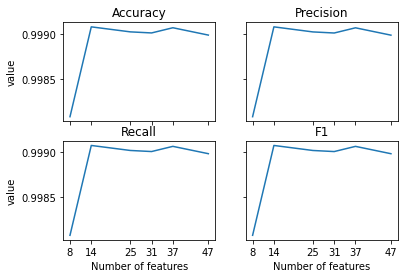

In [ ]:
plot_test_ig(rf_accuracy, rf_precision, rf_recall, rf_f1)

In [ ]:
print(rf_report[2])

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    419297
           1       1.00      1.00      1.00     85176

    accuracy                           1.00    504473
   macro avg       1.00      1.00      1.00    504473
weighted avg       1.00      1.00      1.00    504473





---


Decision Tree

In [ ]:
dt = DecisionTreeClassifier()
dt_trained, dt_accuracy, dt_precision, dt_recall, dt_f1, dt_report, dt_cm = test_ig(dt)

append_result('Decision Tree', dt_trained, dt_accuracy, dt_precision, dt_recall, dt_f1, dt_cm)

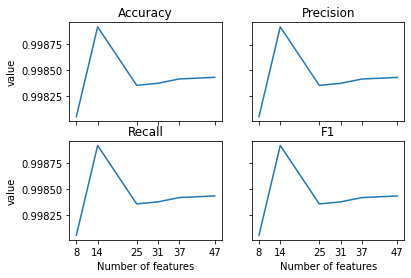

In [ ]:
plot_test_ig(dt_accuracy, dt_precision, dt_recall, dt_f1)

In [ ]:
print(dt_report[1])

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    419297
           1       1.00      0.99      1.00     85176

    accuracy                           1.00    504473
   macro avg       1.00      1.00      1.00    504473
weighted avg       1.00      1.00      1.00    504473





---


XGBoost

In [ ]:
xgb = XGBClassifier(tree_method='gpu_exact', predictor='gpu_predictor', objective="binary:logistic", random_state=42)
xgb_trained, xgb_accuracy, xgb_precision, xgb_recall, xgb_f1, xgb_report, xgb_cm = test_ig(xgb)

append_result('XGBoost', xgb_trained, xgb_accuracy, xgb_precision, xgb_recall, xgb_f1, xgb_cm)

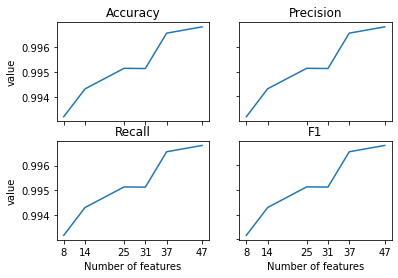

In [ ]:
plot_test_ig(xgb_accuracy, xgb_precision, xgb_recall, xgb_f1)

In [ ]:
print(xgb_report[0])

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    419297
           1       0.99      0.99      0.99     85176

    accuracy                           1.00    504473
   macro avg       1.00      0.99      0.99    504473
weighted avg       1.00      1.00      1.00    504473





---


KNN

In [ ]:
knn = KNeighborsClassifier(n_neighbors=2)
knn_trained, knn_accuracy, knn_precision, knn_recall, knn_f1, knn_report, knn_cm = test_ig(knn)

append_result('KNN', knn_trained, knn_accuracy, knn_precision, knn_recall, knn_f1, knn_cm)

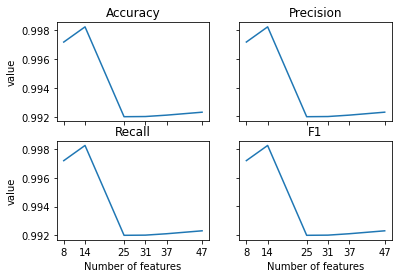

In [ ]:
plot_test_ig(knn_accuracy, knn_precision, knn_recall, knn_f1)

# Comparison of model performance

Bar chart of precision, recall, F1 score for all models

In [ ]:
best_model = "Random Forest"

# Chart colours, markers
colours = {'Decision Tree':'blue',
           'Random Forest': 'orange',
           'XGBoost': 'green',
           'KNN': 'red'}

markers = {'Decision Tree':'o',
           'Random Forest': '*',
           'XGBoost': 's',
           'KNN': 'v'}

def plot_metrics():
    # models = ['Decision Tree','Random Forest','XGBoost', 'KNN']
    X = ['Precision','Recall','F1-score']

    for i in range(len(x_axis)):
        dt = [dt_precision[i]*100, dt_recall[i]*100, dt_f1[i]*100]
        rf = [rf_precision[i]*100, rf_recall[i]*100, rf_f1[i]*100]
        xgb = [xgb_precision[i]*100, xgb_recall[i]*100, xgb_f1[i]*100]
        knn = [knn_precision[i]*100, knn_recall[i]*100, knn_f1[i]*100]
        
        X_axis = np.arange(len(X))

        plt.figure(figsize=(9,5))
        plt.rc('axes', labelsize=18)
        plt.rc('xtick', labelsize=16) 
        plt.rc('ytick', labelsize=16) 
        
        plt.bar(X_axis - 0.3, rf, 0.2, color="white", edgecolor=colours['Random Forest'], linewidth=2, hatch=markers['Random Forest'])
        plt.bar(X_axis - 0.1, dt, 0.2, color="white", edgecolor=colours['Decision Tree'], linewidth=2, hatch=markers['Decision Tree'])
        plt.bar(X_axis + 0.1, xgb, 0.2, color="white", edgecolor=colours['XGBoost'], linewidth=2, hatch='+')
        plt.bar(X_axis + 0.3, knn, 0.2, color="white", edgecolor=colours['KNN'], linewidth=2, hatch='x')
        
        plt.xticks(X_axis, X)
        plt.ylim(99.3,100)
        plt.ylabel("Percentage (%)")
        plt.legend(['RF','DT','XGB','KNN'], loc="upper center", ncol=len(model_list), prop={'size': 14})

        if i==4:
            plt.savefig("plots/barChart.pdf", format="pdf")
        
        plt.show()

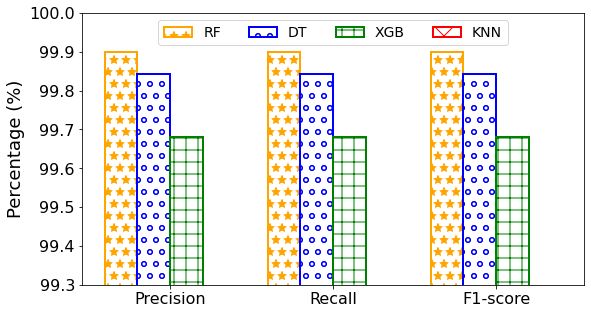

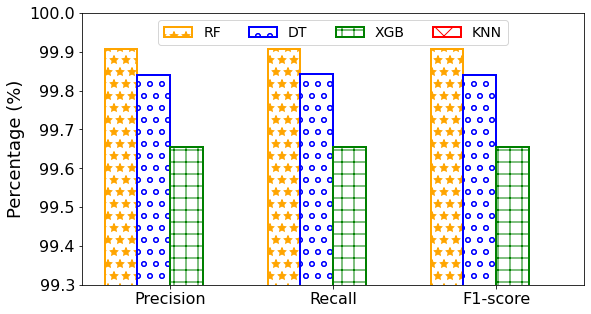

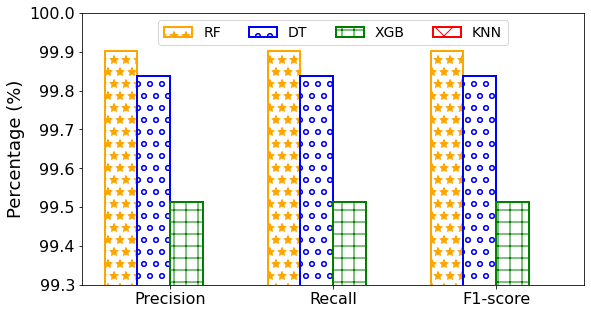

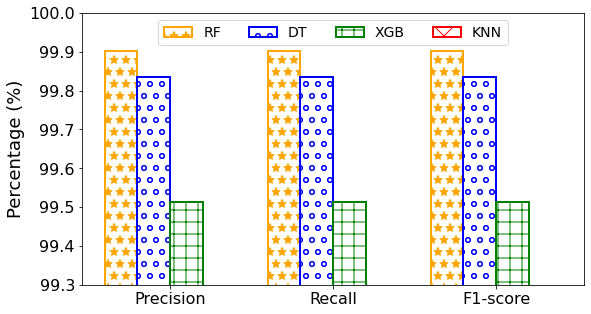

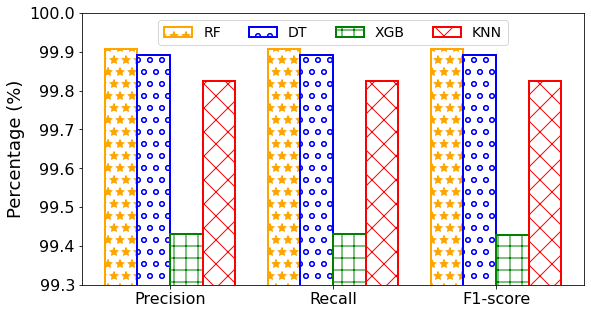

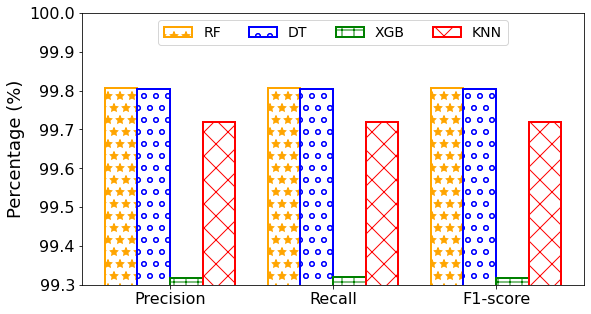

In [ ]:
plot_metrics()

table of accuracy, precision, recall, F1 score

In [ ]:
metrics = ['Accuracy','Precision','Recall','F1']


index = [
         np.array([x_axis[0]]*len(model_list)+[x_axis[1]]*len(model_list)+[x_axis[2]]*len(model_list)+[x_axis[3]]*len(model_list)+[x_axis[4]]*len(model_list)+[x_axis[5]]*len(model_list)),
         np.array(model_list*len(ig_test_values))
]



data = []
for i in range(len(ig_test_values)):
    for model in model_list:
        row = []
        row.append(accuracy_dict[model][i])
        row.append(precision_dict[model][i])
        row.append(recall_dict[model][i])
        row.append(f1_dict[model][i])

        data.append(row)

table = pd.DataFrame(data, columns=metrics, index=index)
table.index.names = ['Number of features','Model']
table

Accuracy  Precision    Recall        F1
Number of features Model                                                 
47                 Random Forest  0.998985   0.998985  0.998985  0.998985
                   Decision Tree  0.998432   0.998431  0.998432  0.998432
                   XGBoost        0.996809   0.996805  0.996809  0.996804
                   KNN            0.992315   0.992296  0.992315  0.992280
37                 Random Forest  0.999066   0.999067  0.999066  0.999066
                   Decision Tree  0.998416   0.998416  0.998416  0.998416
                   XGBoost        0.996555   0.996551  0.996555  0.996549
                   KNN            0.992111   0.992090  0.992111  0.992075
31                 Random Forest  0.999009   0.999009  0.999009  0.999009
                   Decision Tree  0.998375   0.998374  0.998375  0.998374
                   XGBoost        0.995134   0.995126  0.995134  0.995120
                   KNN            0.992013   0.991992  0.992013  0.991977
25                 Random Forest  0.999021   0.999021  0.999021  0.999021
                   Decision Tree  0.998355   0.998354  0.998355  0.998354
                   XGBoost        0.995141   0.995134  0.995141  0.995128
                   KNN            0.992002   0.991980  0.992002  0.991965
14                 Random Forest  0.999076   0.999077  0.999076  0.999077
                   Decision Tree  0.998920   0.998921  0.998920  0.998920
                   XGBoost        0.994315   0.994309  0.994315  0.994292
                   KNN            0.998254   0.998252  0.998254  0.998253
8                  Random Forest  0.998081   0.998080  0.998081  0.998080
                   Decision Tree  0.998051   0.998050  0.998051  0.998051
                   XGBoost        0.993197   0.993184  0.993197  0.993168
                   KNN            0.997195   0.997192  0.997195  0.997191

Accuracy line chart

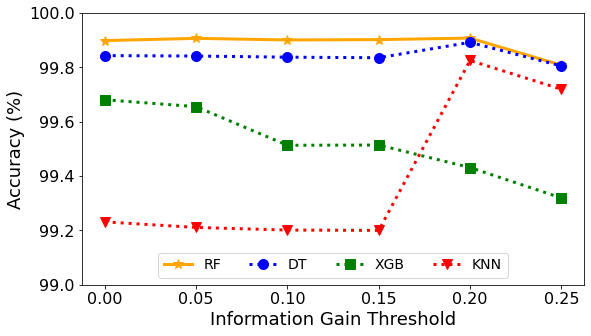

In [ ]:
# Line chart
plt.figure(figsize=(9,5))
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)


for model in accuracy_dict:
    line_style = "-" if model=='Random Forest' else ':'
    values = []
    for value in accuracy_dict[model]:
        values.append(value*100)
    plt.plot(ig_test_values, values, label=model, color=colours[model], ls=line_style, linewidth = '3', marker = markers[model], ms='10')

plt.xticks(ig_test_values)
plt.ylim(99,100)
plt.legend(['RF','DT','XGB','KNN'], loc="lower center", ncol=len(model_list), prop={'size': 14})
plt.xlabel('Information Gain Threshold')
plt.ylabel('Accuracy (%)')
# plt.title('Accuracy of models')
plt.savefig("plots/acc.pdf", format="pdf")
plt.show()

<h2>FPR line chart</h2>

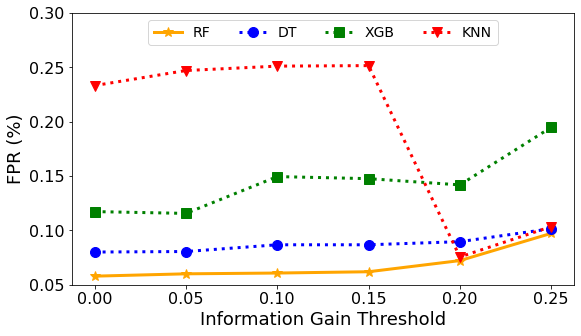

In [ ]:
plt.figure(figsize=(9,5))
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

for model in cm_dict:
    fpr_line = []
    line_style = "-" if model==best_model else ':'
    for cm in cm_dict[model]:
        negative = cm[0][0]+cm[0][1]
        fpr = cm[0][1]*100/negative
        fpr_line.append(fpr)
    plt.plot(ig_test_values, fpr_line, label=model, color=colours[model], ls=line_style, linewidth = '3', marker = markers[model], ms='10')
plt.xticks(ig_test_values)
plt.xlabel('Information Gain Threshold')
plt.ylabel('FPR (%)')
plt.legend(['RF','DT','XGB','KNN'], loc="upper center", ncol=len(model_list), prop={'size': 14})
plt.ylim(0.05,0.3)
plt.savefig("plots/FPR.pdf", format="pdf")
plt.show()

<h2>FNR line chart</h2>

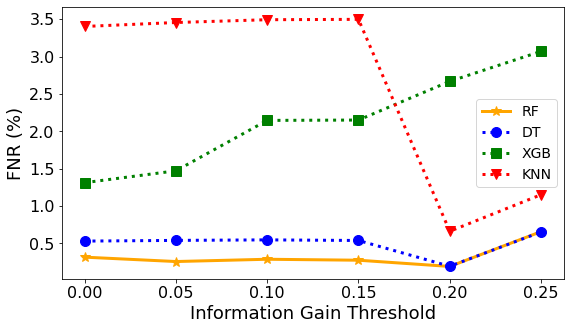

In [ ]:
plt.figure(figsize=(9,5))
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

for model in cm_dict:
    fnr_line = []
    line_style = "-" if model==best_model else ':'
    for cm in cm_dict[model]:
        positive = cm[1][0]+cm[1][1]
        fnr = cm[1][0]*100/positive
        fnr_line.append(fnr)
    plt.plot(ig_test_values, fnr_line, label=model, color=colours[model], ls=line_style, linewidth = '3', marker = markers[model], ms='10')
plt.xticks(ig_test_values)
plt.xlabel('Information Gain Threshold')
plt.ylabel('FNR (%)')
plt.legend(['RF','DT','XGB','KNN'], loc="center right", prop={'size': 14})
# plt.ylim(0.0,4)
plt.savefig("plots/FNR.pdf", format="pdf")
plt.show()

# Extract anomaly data for the second layer multiclass classification IDS

save model

In [ ]:
import joblib
joblib.dump(rf_trained[4], "./random_forest_best.joblib")

['./random_forest_best.joblib']

load model

In [ ]:
import joblib
loaded_rf = joblib.load("./random_forest_best.joblib")

In [ ]:
selected_ig = 0.2
selected_cols = [key for key, val in ig_result.items() if val >= selected_ig]

In [ ]:
predict = loaded_rf.predict(X_test[selected_cols])

In [ ]:
rf_cm[4]

array([[418994,    303],
       [   163,  85013]])

Extract anomaly data

In [ ]:
correct_label_data_index = np.where((predict == 1) & (np.equal(predict, Y_test)))[0]

In [ ]:
len(np.where((predict == 1) & (np.equal(predict, Y_test)))[0])

85013

In [ ]:
X_test_anomaly = X_test.iloc[correct_label_data_index]
Y_test_anomaly = Y_test[correct_label_data_index]
Y_test_anomaly

array([1, 1, 1, ..., 1, 1, 1])



---

# Multiclass classification

Random Forest

In [ ]:
rf = RandomForestClassifier(n_jobs=-1, random_state=42)

rf.fit(X_train[selected_cols], Y_train_multi)
predict = rf.predict(X_test[selected_cols])

accuracy_multiclass = accuracy_score(y_true=Y_test_multi, y_pred=predict)
precision_multiclass = precision_score(y_true=Y_test_multi, y_pred=predict, average='weighted')
recall_multiclass = recall_score(y_true=Y_test_multi, y_pred=predict, average='weighted')
f1_multiclass = f1_score(y_true=Y_test_multi, y_pred=predict, average='weighted')
report_multiclass = classification_report(y_true=Y_test_multi, y_pred=predict)
cm_multiclass = confusion_matrix(y_true=Y_test_multi, y_pred=predict)

In [1]:
print("Accuracy of multiclass RF = ", accuracy_multiclass)

Accuracy of multiclass RF = 0.998691704015874


In [ ]:
unique, counts = np.unique(predict, return_counts=True)
print("Multiclass classifier \n (Random Forest)")
print(np.asarray((unique, counts)).T)

Multiclass classifier 
 (Random Forest)
[[     0 419162]
 [     1    334]
 [     2  25646]
 [     3   2076]
 [     4  34554]
 [     5   1077]
 [     6   1075]
 [     7   1186]
 [     8      4]
 [     9      5]
 [    10  18317]
 [    11    644]
 [    12    269]
 [    13      2]
 [    14    122]]


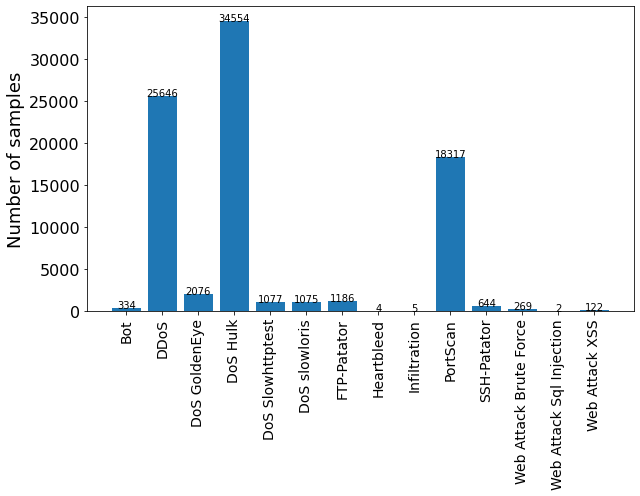

In [ ]:
plt.figure(figsize=(9,7))
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=16)

plt.bar((multiclass_le.classes_)[1:], counts[1:])
for i in range(len(multiclass_le.classes_)-1):
    plt.text(i,counts[i+1],counts[i+1], ha = 'center')
plt.xticks((multiclass_le.classes_)[1:], rotation=90)
plt.ylabel("Number of samples")
plt.tight_layout()
plt.savefig("plots/multiclass_RF_distribution.pdf", format="pdf")
plt.show()

class distribution of testing data

In [ ]:
unique, counts = np.unique(Y_test_multi, return_counts=True)
print("True label")
print(np.asarray((unique, counts)).T)

True label
[[     0 419297]
 [     1    398]
 [     2  25648]
 [     3   2072]
 [     4  34497]
 [     5   1071]
 [     6   1074]
 [     7   1187]
 [     8      4]
 [     9      7]
 [    10  18153]
 [    11    644]
 [    12    281]
 [    13      4]
 [    14    136]]


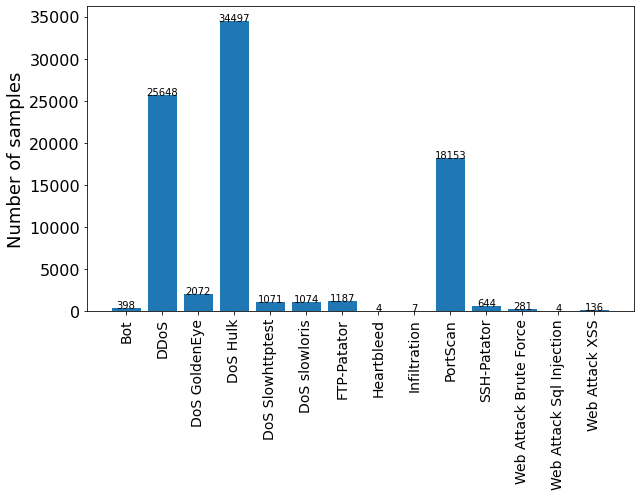

In [ ]:
plt.figure(figsize=(9,7))
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=16)

plt.bar((multiclass_le.classes_)[1:], counts[1:])
for i in range(len(multiclass_le.classes_)-1):
    plt.text(i,counts[i+1],counts[i+1], ha = 'center')
plt.xticks((multiclass_le.classes_)[1:], rotation=90)
plt.ylabel("Number of samples")
plt.tight_layout()
plt.savefig("plots/true_distribution.pdf", format="pdf")
plt.show()